c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Data Training] Semua data lengkap, gak ada yang kosong.
Mulai latihan model, sabar ya...


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Hasil evaluasi model:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3046
           1       0.52      0.49      0.50       392

    accuracy                           0.89      3438
   macro avg       0.73      0.72      0.72      3438
weighted avg       0.89      0.89      0.89      3438

AUC yang didapet: 0.7980

Modelnya udah disimpan di 'deposito_predictor.pkl'

Plot fitur penting udah disimpan di 'feature_importance.png'


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Plot SHAP summary udah disimpan di 'shap_summary.png'
Gagal generate penjelasan SHAP: too many indices for array: array is 1-dimensional, but 2 were indexed

File submission berhasil dibuat di 'submission.csv'

Preview hasil submission:
   customer_number  berlangganan_deposito
0           907098               0.082561
1           699895               0.052768
2           440407               0.080312
3           787412               0.199796
4           891667               0.075372


c:\Users\RLION\anaconda3\envs\TF\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


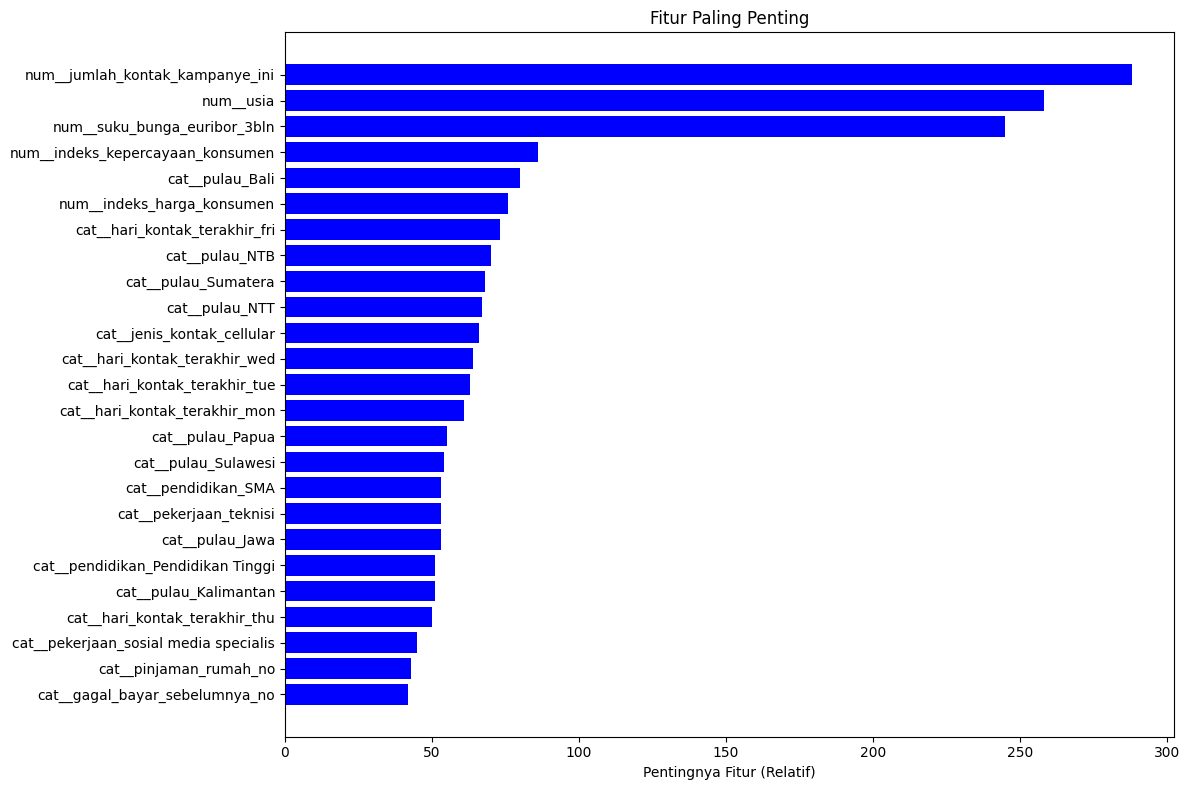

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin


# 1. Load data dan cek data
def load_data(path):
    return pd.read_csv(path)


def check_missing_values(df, name="Dataset"):
    missing = df.isnull().sum()
    total_missing = missing.sum()
    if total_missing > 0:
        print(f"[{name}] Ada data yang kosong:")
        print(missing[missing > 0])
    else:
        print(f"[{name}] Semua data lengkap, gak ada yang kosong.")


# 2. Bikin fitur baru
class BusinessFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # 1. Fitur buat ngecek kapasitas finansial
        if all(col in X.columns for col in ['balance', 'income']):
            X['savings_ratio'] = X['balance'] / (X['income'] + 1)
            X['balance_income_interaction'] = X['balance'] * X['income']
            X['financial_stability'] = np.log1p(X['balance']) - np.log1p(X['income'])
            X['income_to_age_ratio'] = X['income'] / (X['age'] + 1)

        # 2. Bagi umur jadi kelompok yang lebih detail
        if 'age' in X.columns:
            bins = [18, 25, 35, 45, 55, 65, 100]
            labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
            X['age_group'] = pd.cut(X['age'], bins=bins, labels=labels)
            X['age_squared'] = X['age'] ** 2
            X['is_senior'] = (X['age'] >= 60).astype(int)

        # 3. Fitur buat ngukur seberapa rajin respon kampanye
        if all(col in X.columns for col in ['previous_campaign_contacts', 'previous_campaign_success']):
            X['engagement_intensity'] = np.where(
                X['previous_campaign_contacts'] > 0,
                X['previous_campaign_success'] / X['previous_campaign_contacts'],
                0
            )
            X['high_engagement'] = (X['previous_campaign_contacts'] > np.percentile(
                X['previous_campaign_contacts'], 75)).astype(int)
            X['responsive_client'] = (X['engagement_intensity'] > 0.5).astype(int)
            X['campaign_frequency'] = np.log1p(X['previous_campaign_contacts'])

        # 4. Fitur berdasarkan durasi kontak terakhir
        if 'last_contact_duration' in X.columns:
            X['contact_efficiency'] = np.log1p(X['last_contact_duration']) / (
                np.log1p(X['previous_campaign_contacts']) + 1)
            X['duration_bins'] = pd.qcut(X['last_contact_duration'], 5, labels=False, duplicates='drop')
            X['duration_per_contact'] = X['last_contact_duration'] / (X['previous_campaign_contacts'] + 1)

        # 5. Fitur interaksi antara umur dan saldo / penghasilan
        if all(col in X.columns for col in ['age', 'balance']):
            X['age_balance_interaction'] = X['age'] * X['balance']
            X['age_income_interaction'] = X['age'] * X['income']

        # 6. Fitur polinomial buat balance
        if 'balance' in X.columns:
            X['balance_squared'] = X['balance'] ** 2
            X['balance_log'] = np.log1p(X['balance'])
            X['balance_per_age'] = X['balance'] / (X['age'] + 1)

        # 7. Fitur lama jadi customer
        if 'customer_since' in X.columns:
            X['customer_since'] = pd.to_datetime(X['customer_since'], errors='coerce')
            X['customer_tenure'] = 2023 - X['customer_since'].dt.year
            X['tenure_group'] = pd.cut(X['customer_tenure'], bins=[0, 2, 5, 10, 20, 100],
                                      labels=['0-2', '3-5', '6-10', '11-20', '20+'])

        return X


# 3. Biar modelnya bisa dijelasin (interpretasi)
def plot_feature_importance(model, X_val):
    try:
        # Ambil nama fitur abis preprocessing
        if hasattr(model.named_steps['preprocessor'], 'get_feature_names_out'):
            feature_names = model.named_steps['preprocessor'].get_feature_names_out()
        else:
            feature_names = X_val.columns.tolist()

        # Bikin plot fitur pentingnya
        plt.figure(figsize=(12, 8))
        importances = model.named_steps['classifier'].named_estimators_['lgbm'].feature_importances_
        indices = np.argsort(importances)[-25:]  # Ambil 25 fitur teratas
        plt.title('Fitur Paling Penting')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Pentingnya Fitur (Relatif)')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        print("\nPlot fitur penting udah disimpan di 'feature_importance.png'")
    except Exception as e:
        print(f"Gagal bikin plot fitur penting: {str(e)}")


def explain_model(model, X_val, sample_idx=0):
    try:
        # Terapkan transformasi fitur bisnis dan preprocessing
        business_features = model.named_steps['business_features'].transform(X_val)
        preprocessed_data = model.named_steps['preprocessor'].transform(business_features)

        # Buat explainer untuk model tree-based
        explainer = shap.TreeExplainer(model.named_steps['classifier'].named_estimators_['lgbm'])
        shap_values = explainer.shap_values(preprocessed_data)

        # Plot ringkas SHAP
        plt.figure()
        shap.summary_plot(shap_values, preprocessed_data,
                         feature_names=model.named_steps['preprocessor'].get_feature_names_out(),
                         plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Plot SHAP summary udah disimpan di 'shap_summary.png'")

        # Plot force plot buat contoh satu sampel (disimpan jadi gambar)
        shap.force_plot(explainer.expected_value, shap_values[0][sample_idx, :],
                        preprocessed_data[sample_idx, :],
                        feature_names=model.named_steps['preprocessor'].get_feature_names_out(),
                        matplotlib=True, show=False)
        plt.tight_layout()
        plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Plot SHAP force udah disimpen di 'shap_force_plot.png'")

        # Plot keputusan SHAP (decision plot)
        plt.figure()
        shap.decision_plot(explainer.expected_value, shap_values[0][:100, :],
                          feature_names=model.named_steps['preprocessor'].get_feature_names_out(),
                          show=False)
        plt.tight_layout()
        plt.savefig('shap_decision_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Plot SHAP decision udah disimpen di 'shap_decision_plot.png'")

    except Exception as e:
        print(f"Gagal generate penjelasan SHAP: {str(e)}")


# 4. Generate file submission
def generate_submission_file(model, X_val, original_val_data):
    """
    Generate submission file dengan format yang diminta
    
    Args:
        model: Model yang sudah dilatih
        X_val: Data validasi (features)
        original_val_data: Data validasi original (termasuk customer_number)
    """
    try:
        # Dapatkan probabilitas prediksi
        y_proba = model.predict_proba(X_val)[:, 1]
        
        # Buat DataFrame hasil
        submission_df = pd.DataFrame({
            'customer_number': original_val_data['customer_number'].values,
            'berlangganan_deposito': y_proba
        })
        
        # Pastikan urutan kolom benar
        submission_df = submission_df[['customer_number', 'berlangganan_deposito']]
        
        # Simpan ke CSV
        submission_df.to_csv('submission.csv', index=False)
        print("\nFile submission berhasil dibuat di 'submission.csv'")
        
        # Tampilkan preview
        print("\nPreview hasil submission:")
        print(submission_df.head())
        
    except Exception as e:
        print(f"Gagal membuat file submission: {str(e)}")


# 5. Latih model dan evaluasi dengan cara stacking
def train_and_evaluate():
    # Load data
    train_df = load_data("training_dataset.csv")
    check_missing_values(train_df, "Data Training")

    # Pisah fitur sama target
    X = train_df.drop(columns=['berlangganan_deposito', 'customer_number'])
    y = train_df['berlangganan_deposito']

    # Split data buat training dan validasi dengan stratifikasi biar seimbang
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
    # Simpan data validasi original (untuk mendapatkan customer_number)
    original_val_data = train_df.iloc[X_val.index].copy()

    # Bedain mana fitur numerik sama kategorikal
    num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X_train.select_dtypes(include='object').columns.tolist()

    # Bikin pipeline preprocessing yang keren
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

    # Model dasar buat stacking
    lgbm = LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

    # Logistic Regression sebagai meta model
    lr_meta = LogisticRegression(max_iter=1000)

    # Definisi model stacking
    stacking_model = StackingClassifier(
        estimators=[('lgbm', lgbm)],
        final_estimator=lr_meta,
        cv=5,
        n_jobs=-1,
        passthrough=True
    )

    # SMOTE supaya data gak imbang
    smote = SMOTE(random_state=42)

    # Pipeline lengkap mulai dari fitur bisnis sampe model
    pipeline = ImbPipeline(steps=[
        ('business_features', BusinessFeatureTransformer()),
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', stacking_model)
    ])

    # Latih modelnya
    print("Mulai latihan model, sabar ya...")
    pipeline.fit(X_train, y_train)

    # Prediksi dan evaluasi
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    print("\nHasil evaluasi model:")
    print(classification_report(y_val, y_pred))

    print(f"AUC yang didapet: {roc_auc_score(y_val, y_proba):.4f}")

    # Simpan model buat nanti dipake
    with open("deposito_predictor.pkl", "wb") as f:
        pickle.dump(pipeline, f)
    print("\nModelnya udah disimpan di 'deposito_predictor.pkl'")

    # Bikin plot fitur penting
    plot_feature_importance(pipeline, X_val)

    # Jelasin pake SHAP
    explain_model(pipeline, X_val)
    
    # Generate file submission
    generate_submission_file(pipeline, X_val, original_val_data)


if __name__ == "__main__":
    train_and_evaluate()